Installing needed libraries:

In [ ]:
pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.1 MB/s eta 0:00:00


In [ ]:
pip install Flask


In [ ]:
!pip install flask-cors


In [ ]:
!pip install pyngrok

In [ ]:
!npm install -g localtunnel


/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 4.59s


Importing needed assets from Kaggle:

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset -p /root/.kaggle

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
License(s): copyright-authors
100% 23.1G/23.1G [04:32<00:00, 58.8MB/s]
100% 23.1G/23.1G [04:32<00:00, 91.0MB/s]


In [ ]:
!yes | unzip /root/.kaggle/fashion-product-images-dataset.zip -d /content/Fashion_images_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/Fashion_images_dataset/fashion-dataset/styles/58128.json  
  inflating: /content/Fashion_images_dataset/fashion-dataset/styles/58129.json  
  inflating: /content/Fashion_images_dataset/fashion-dataset/styles/5813.json  
  inflating: /content/Fashion_images_dataset/fashion-dataset/styles/58131.json  
  inflating: /content/Fashion_images_dataset/fashion-dataset/styles/58132.json  
  inflating: /content/Fashion_images_dataset/fashion-dataset/styles/58133.json  
  inflating: /content/Fashion_images_dataset/fashion-dataset/styles/58135.json  
  inflating: /content/Fashion_images_dataset/fashion-dataset/styles/58136.json  
  inflating: /content/Fashion_images_dataset/fashion-dataset/styles/58137.json  
  inflating: /content/Fashion_images_dataset/fashion-dataset/styles/58138.json  
  inflating: /content/Fashion_images_dataset/fashion-dataset/styles/58139.json  
  inflating: /content/Fashion_images_dataset/fashion-datase

Search by image + API

In [ ]:
# Start a local HTTP server to serve the images
import os
import threading
import http.server
import socketserver

def start_server(directory, port=2000):
    os.chdir(directory)
    handler = http.server.SimpleHTTPRequestHandler
    httpd = socketserver.TCPServer(("", port), handler)
    print(f"Serving HTTP on 0.0.0.0 port {port} ...")
    httpd.serve_forever()

# Directory containing your images
image_directory = "/content/Fashion_images_dataset/fashion-dataset/images"

# Start the server in a new thread
server_thread = threading.Thread(target=start_server, args=(image_directory, 2000))
server_thread.start()


Serving HTTP on 0.0.0.0 port 2000 ...


In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
import requests
from io import BytesIO
from PIL import Image
import threading

app = Flask(__name__)
CORS(app)  # Enable CORS

# Initialize the VGG16 model
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

def extract_features(img):
    try:
        img = img.resize((224, 224))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        features = model.predict(img_data)
        return features
    except Exception as e:
        print(f"Error extracting features from the image: {e}")
        return None

def find_similar_images(img_features, database_features, top_n=5):
    similarities = cosine_similarity(img_features, database_features)
    best_match_indices = np.argsort(similarities[0])[::-1][:top_n]
    return best_match_indices

# Load precomputed database features and image paths
database_features_path = '/content/drive/MyDrive/28-5-2024/database_features_subset.npy'
image_ids_path = '/content/drive/MyDrive/28-5-2024/image_ids_subset.npy'

database_features = np.load(database_features_path)
image_ids = np.load(image_ids_path)

@app.route('/find-similar-images', methods=['POST'])
def find_similar_images_endpoint():
    data = request.json
    image_url = data.get('image_url')
    print(f"Received image_url: {image_url}")

    if not image_url:
        return jsonify({"error": "Image URL is required"}), 400

    try:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
    except Exception as e:
        return jsonify({"error": f"Failed to load image from URL: {e}"}), 400

    test_features = extract_features(img)
    if test_features is None:
        return jsonify({"error": "Error extracting features from the image"}), 500

    similar_indices = find_similar_images(test_features, database_features, top_n=10)
    similar_image_ids = [int(image_ids[idx]) for idx in similar_indices]  # Convert to Python int

    return jsonify({"similar_image_ids": similar_image_ids})

def run_flask():
    app.run(port=2001)  # Change the port to 8000

# Run the Flask app in a separate thread
thread = threading.Thread(target=run_flask)
thread.start()


553467096/553467096 [==============================] - 4s 0us/step


In [ ]:
# Use localtunnel to expose the Flask app
!lt --port 2001 --subdomain search-by-imagee

your url is: https://search-by-imagee.loca.lt
Received image_url: http://assets.myntassets.com/assets/images/56019/2019/1/11/49d718c4-6d86-42d1-8d00-1ce4b7851b2c1547190759839-Colorbar-Soft-Touch-Show-Stopper-Copper-Lipstick-037-2715471-1.jpg
1/1 [==============================] - 1s 1s/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 07:48:23] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://assets.myntassets.com/v1/images/style/properties/c8dfda128eced87bc4868f528255f531_images.jpg
1/1 [==============================] - 1s 564ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 07:57:40] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://assets.myntassets.com/v1/images/style/properties/c8dfda128eced87bc4868f528255f531_images.jpg
1/1 [==============================] - 1s 549ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 07:57:54] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: https://firebasestorage.googleapis.com/v0/b/stylesphere-graduation.appspot.com/o/Hoddie_hazem.jpg?alt=media&token=e32b1e66-ce6b-4495-8ecc-45f11fcc1a44
1/1 [==============================] - 1s 612ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 07:58:03] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: https://firebasestorage.googleapis.com/v0/b/stylesphere-graduation.appspot.com/o/Hoddie_hazem.jpg?alt=media&token=e32b1e66-ce6b-4495-8ecc-45f11fcc1a44
1/1 [==============================] - 1s 552ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 07:58:26] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://assets.myntassets.com/v1/images/style/properties/7c4fb6d7e77f1d0c8469800f52c20cbc_images.jpg
1/1 [==============================] - 1s 614ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 08:06:13] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://assets.myntassets.com/v1/images/style/properties/730948b34fc665e785b1912e56a573c1_images.jpg
1/1 [==============================] - 1s 538ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 08:07:27] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://assets.myntassets.com/v1/images/style/properties/Arrow-Men-Blue-Striped-Shirt_6fd108d63d0ade4dc7ed090e1ffefd3c_images.jpg
1/1 [==============================] - 1s 574ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 08:11:06] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: https://firebasestorage.googleapis.com/v0/b/stylesphere-graduation.appspot.com/o/6679e1cd37f1495b633a415c_Ahmed%20Naeim%20search?alt=media&token=46e4d979-871c-4576-856e-3c44e8c64398
1/1 [==============================] - 1s 559ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 08:13:01] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://assets.myntassets.com/v1/images/style/properties/3d8b78b013627f7e9d738ccec2972480_images.jpg
1/1 [==============================] - 1s 569ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 08:16:25] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://assets.myntassets.com/v1/images/style/properties/Arrow-Men-Blue-Striped-Shirt_6fd108d63d0ade4dc7ed090e1ffefd3c_images.jpg
1/1 [==============================] - 1s 548ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 08:17:45] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: https://firebasestorage.googleapis.com/v0/b/stylesphere-graduation.appspot.com/o/Hoddie_hazem.jpg?alt=media&token=e32b1e66-ce6b-4495-8ecc-45f11fcc1a44
1/1 [==============================] - 1s 957ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 08:25:35] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: https://firebasestorage.googleapis.com/v0/b/stylesphere-graduation.appspot.com/o/6637fd68aecc4398ddb97ee7_Nemo%20%20search?alt=media&token=982a8051-0cbd-41d9-bf3d-a3f952aaa2fc
1/1 [==============================] - 1s 575ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 08:58:08] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://0.0.0.0:2000/11170.jpg


127.0.0.1 - - [25/Jun/2024 09:10:53] "GET /11170.jpg HTTP/1.1" 200 -


1/1 [==============================] - 1s 622ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 09:10:55] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://0.0.0.0:2000/11170.jpg


127.0.0.1 - - [25/Jun/2024 09:12:29] "GET /11170.jpg HTTP/1.1" 200 -


1/1 [==============================] - 1s 779ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 09:12:31] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://0.0.0.0:2000/11170.jpg


127.0.0.1 - - [25/Jun/2024 09:14:20] "GET /11170.jpg HTTP/1.1" 200 -


1/1 [==============================] - 1s 583ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 09:14:21] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://0.0.0.0:2000/11171.jpg


127.0.0.1 - - [25/Jun/2024 09:18:34] "GET /11171.jpg HTTP/1.1" 200 -


1/1 [==============================] - 1s 557ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 09:18:36] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://assets.myntassets.com/v1/images/style/properties/Arrow-Men-Blue-Striped-Shirt_6fd108d63d0ade4dc7ed090e1ffefd3c_images.jpg
1/1 [==============================] - 1s 565ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 09:22:07] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://0.0.0.0:2000/11171.jpg


127.0.0.1 - - [25/Jun/2024 09:56:38] "GET /11171.jpg HTTP/1.1" 200 -


1/1 [==============================] - 1s 595ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 09:56:40] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: https://firebasestorage.googleapis.com/v0/b/stylesphere-graduation.appspot.com/o/667a946a833cad11209973c0_ahned%20naein%20search?alt=media&token=d43e9a3a-ddb0-49e5-91b1-6059a377497d
1/1 [==============================] - 1s 966ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 09:59:32] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: https://firebasestorage.googleapis.com/v0/b/stylesphere-graduation.appspot.com/o/667a946a833cad11209973c0_ahned%20naein%20search?alt=media&token=b925aa03-f697-4015-8c48-d870e6442ada
1/1 [==============================] - 1s 1s/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 10:04:22] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: https://firebasestorage.googleapis.com/v0/b/stylesphere-graduation.appspot.com/o/667a946a833cad11209973c0_ahned%20naein%20search?alt=media&token=3abff241-53b1-42d5-bcb1-3c94ac2cd382
1/1 [==============================] - 1s 963ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 10:05:01] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: https://firebasestorage.googleapis.com/v0/b/stylesphere-graduation.appspot.com/o/Hoddie_hazem.jpg?alt=media&token=e32b1e66-ce6b-4495-8ecc-45f11fcc1a44
1/1 [==============================] - 1s 560ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 10:06:49] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: https://firebasestorage.googleapis.com/v0/b/stylesphere-graduation.appspot.com/o/Hoddie_hazem.jpg?alt=media&token=e32b1e66-ce6b-4495-8ecc-45f11fcc1a44
1/1 [==============================] - 1s 909ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 10:10:14] "POST /find-similar-images HTTP/1.1" 200 -


Received image_url: http://assets.myntassets.com/v1/images/style/properties/Arrow-Men-Blue-Striped-Shirt_6fd108d63d0ade4dc7ed090e1ffefd3c_images.jpg
1/1 [==============================] - 1s 561ms/step


INFO:werkzeug:127.0.0.1 - - [25/Jun/2024 10:13:08] "POST /find-similar-images HTTP/1.1" 200 -


Code to empty the port:

In [ ]:
import os
import subprocess

# Function to find the process ID (PID) using a specific port
def find_process_using_port(port):
    result = subprocess.run(['lsof', '-i', f':{port}'], stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8').strip().split('\n')
    if len(output) > 1:
        # Extract the PID from the second line of the output
        pid = int(output[1].split()[1])
        return pid
    return None

# Function to kill a process by its PID
def kill_process(pid):
    os.kill(pid, 9)

# Port you want to clear
port = 2000

# Find the process using the port
pid = find_process_using_port(port)
if pid:
    print(f"Found process using port {port}: PID {pid}")
    kill_process(pid)
    print(f"Process {pid} killed.")
else:
    print(f"No process found using port {port}.")


No process found using port 2000.


Only for testing:

In [ ]:
!pip install requests matplotlib pillow


Received image_url: http://0.0.0.0:2000/amees.jpg


127.0.0.1 - - [24/Jun/2024 16:41:59] "GET /amees.jpg HTTP/1.1" 200 -


1/1 [==============================] - 2s 2s/step


INFO:werkzeug:127.0.0.1 - - [24/Jun/2024 16:42:03] "POST /find-similar-images HTTP/1.1" 200 -


Status Code: 200
Response JSON:
{
    "similar_image_ids": [
        19853,
        21023,
        12238,
        23180,
        26077,
        22376,
        27170,
        9067,
        22378,
        24853
    ]
}


127.0.0.1 - - [24/Jun/2024 16:42:03] "GET /19853.jpg HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2024 16:42:03] "GET /21023.jpg HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2024 16:42:04] "GET /12238.jpg HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2024 16:42:04] "GET /23180.jpg HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2024 16:42:04] "GET /26077.jpg HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2024 16:42:04] "GET /22376.jpg HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2024 16:42:04] "GET /27170.jpg HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2024 16:42:04] "GET /9067.jpg HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2024 16:42:04] "GET /22378.jpg HTTP/1.1" 200 -
127.0.0.1 - - [24/Jun/2024 16:42:04] "GET /24853.jpg HTTP/1.1" 200 -


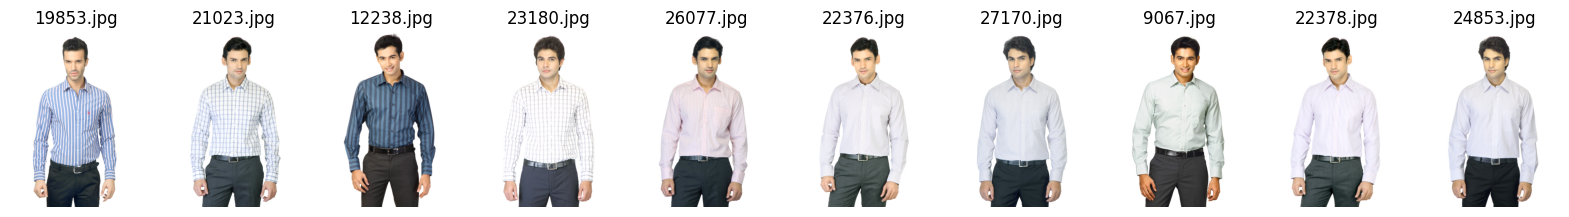

In [ ]:
import requests
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Set the URL of your Flask app endpoint
flask_url = "http://127.0.0.1:2001/find-similar-images"  # Replace with your localtunnel URL if needed

# Example input
input_data = {
    "image_url": "http://0.0.0.0:2000/amees.jpg"
}

# Make a POST request to the Flask endpoint
response = requests.post(flask_url, json=input_data)

# Print the status code and response
print(f"Status Code: {response.status_code}")
response_json = response.json()
print("Response JSON:")
print(json.dumps(response_json, indent=4))

# Display the images based on the similar image IDs
if "similar_image_ids" in response_json:
    similar_image_ids = response_json["similar_image_ids"]
    image_urls = [f"http://0.0.0.0:2000/{image_id}.jpg" for image_id in similar_image_ids]

    # Display the images
    fig, axes = plt.subplots(1, len(image_urls), figsize=(20, 5))
    for ax, image_url in zip(axes, image_urls):
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(image_url.split('/')[-1])
    plt.show()
else:
    print("No similar images found.")


Trial 2:

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import os

# Load the VGG16 model, excluding the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)  # Adjust the number of classes based on your dataset

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with the new learning rate parameter name
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare data generators for training
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# Custom data generator for images without class subdirectories
class CustomDataGenerator:
    def __init__(self, image_dir, batch_size, target_size, preprocess_input, num_classes):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.preprocess_input = preprocess_input
        self.num_classes = num_classes
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]
        self.index = 0

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __iter__(self):
        return self

    def __next__(self):
        batch_images = []
        batch_labels = []
        for _ in range(self.batch_size):
            if self.index >= len(self.image_paths):
                self.index = 0
                raise StopIteration

            img_path = self.image_paths[self.index]
            img = load_img(img_path, target_size=self.target_size)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = self.preprocess_input(img_array)

            batch_images.append(img_array)
            # Dummy one-hot encoded label, replace with actual labels if available
            label = np.zeros(self.num_classes)
            label[np.random.randint(0, self.num_classes)] = 1
            batch_labels.append(label)

            self.index += 1

        return np.vstack(batch_images), np.array(batch_labels)

image_dir = '/content/Fashion_images_dataset/fashion-dataset/images'
batch_size = 32
target_size = (224, 224)
num_classes = 10  # Adjust this based on your dataset

train_generator = CustomDataGenerator(image_dir, batch_size, target_size, preprocess_input, num_classes)

# Reduce the number of steps per epoch for quicker iterations
steps_per_epoch = 100  # Adjust this based on the desired speed and dataset size

# Fine-tune the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10)

# Save the fine-tuned model
model.save('/content/drive/MyDrive/fine_tuned_vgg16.h5')  # Save the model to Google Drive


Epoch 1/10
100/100 [==============================] - 2237s 22s/step - loss: 14.2178 - accuracy: 0.1028
Epoch 2/10
 18/100 [====>.........................] - ETA: 31:14 - loss: 6.3751 - accuracy: 0.1059

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7db147379990>
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "<ipython-input-54-d46298202d3a>", line 56, in __next__
    img = load_img(img_path, target_size=self.target_size)

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py", line 423, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7db147379990>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_10538]